In [3]:
from datascience import Table
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [217]:
M = 5                # number of machines
T = 10000            # number of time units
K = 30               # number of pharmacists

Q: Where to put the K pharmacists on my schedule to maximize work possible on all machines ? 

Constraint: 
 - Per machine at most (k+1) Jobs whose sum(production time) <= T

**Generate Dataset**

1. Simulate sequence of production times

In [218]:
jobs = np.arange(1, (T/2)+2)
jobs

array([1.000e+00, 2.000e+00, 3.000e+00, ..., 4.999e+03, 5.000e+03,
       5.001e+03])

In [219]:
# returs a sequence of the jobs per machine
def generate_sequences(M, K, T, jobs):
    seqs = []
    for i in range(M):
        seq = np.random.choice(jobs, (K+1))
        if (sum(seq) > T):
            seq= truncate(seq, T)
        seqs.append(seq)
    return seqs

# generates a sequence for the pharmacists 
def generate_pharma_seq(K, T):
    units = np.arange(1, T)
    pharma = np.random.choice(units, K, replace=False)
    return sorted(pharma)

# truncates the generated sequence to meet the constraint : sum(jobs) <= T
def truncate(seq, T):
    if (sum(seq) > T):
        seq = seq[seq != sorted(seq,reverse=True)[0]]
        truncate(seq, T)
        return seq
    
# calculates production time given the time the k pharmacists come at 
def production_time(pharma , seq, T):
    approved = []
    prod_time = 0
    elapsed_time = 0
    pharma_seq = pharma.copy()
    
   #  print ("Sequence: ", seq)
     # one job
    for job in seq:  
        # check the length of the pharmacisit array
        
        if (len(pharma_seq)==0):
            elapsed_time = elapsed_time + job
           # print(elapsed_time, "job", job)
            if(elapsed_time > T):
                prod_time = prod_time + job -(elapsed_time-T)
            else:
                prod_time = prod_time + job
           # print("BREAK")
            break
            
        # pop the 1st pharmacist
        k = pharma_seq.pop(0)
        
        elapsed_time = elapsed_time + job
        
        while ((k < elapsed_time) & (len(pharma_seq)> 0)):   # check if the first pharmacist can check it otherwise check the next pharmacist
            k = pharma_seq.pop(0)                            # next pharmacist
        
        if (k < elapsed_time):
            approved.append(False)
        else:
            approved.append(True)
            elapsed_time = k
            
       # print("job: ", job, "elapesed_time: ", elapsed_time, "pharma: ", pharma_seq)
        
        if(elapsed_time > T):             # if the length of the job exceeds T
            prod_time = prod_time + job -(elapsed_time - T)
         #   print("here2", prod_time)
        else:
            prod_time = prod_time + job
         #   print("here", prod_time)
            
        if(approved[-1] == False):
            break
  #  print(approved)
   # print("Prod Time: ", prod_time)
    return prod_time

def idle_time(pharma, seq, T):
    idle  = T - production_time(pharma, seq, T)
   # print(production_time(pharma, seq, T))
    return idle

def idle_time_all_schedule(pharma_seq, seqs, T):
    idle = 0
    for seq in seqs:
        idle  = idle + idle_time(pharma_seq, seq, T)
      #  print(idle)
      #  print(idle_time(pharma_seq, seq, T))
       # print(seq)
    return idle

# calculate production time for a given schedule
def prod_time_all_schedule(pharma_seq, seqs, T):
    prod_time = 0
    for seq in seqs:
        prod_time = prod_time + production_time(pharma_seq, seq, T)
    return prod_time
    

In [220]:
seqs = generate_sequences(M, K, T, jobs)
seqs

[array([1956.,   41., 1261., 1754., 1287.,  287., 1342., 3514.,  795.,
        3915., 1774., 3894., 2112., 4305., 3411.,   53., 1490., 1777.,
        2515.,  438.,  316., 1493., 1623., 3031., 4156., 1163., 3340.,
        1781., 4053., 3401.]),
 array([2473., 3009., 1607., 2022., 4911., 2729., 4132., 2670., 3927.,
        2066.,   45., 4780., 3753., 3445., 4422., 2945., 1641., 3332.,
        4836.,  370., 1686., 1769., 3133., 1223., 3488., 1684., 1070.,
        4521., 3902., 3112.]),
 array([1375., 3137., 3799., 3269., 2175., 3723., 1018., 4105., 3049.,
        2063., 3631.,  770., 1959.,  175.,  187., 2388., 2007., 3328.,
        2914.,   91.,  870., 3338.,   20.,  470., 3597., 2725., 2724.,
        1976., 3263., 1898.]),
 array([ 804., 4167., 4225.,  260., 2320., 2799.,  395., 3691., 2698.,
         889., 4007., 1327., 1266., 1293.,   72., 2764., 3529., 2147.,
        4098., 3991.,  791.,  529., 1947., 4743., 1408.,  492., 3744.,
         515.,  660., 2413.]),
 array([3209., 3678.,  2

**Heuristic Algorithm**

Problem: assign t for each pharmacists such that the total production time is maximized and idle time is minimized. 

hill climbing algorithm --> Simulated annealing

- Let s = s0
- For k = 0 through kmax (exclusive):
- T ← temperature( kmax/(k+1) )
- Pick a random neighbour, snew ← neighbour(s)
- If P(E(s), E(snew), T) ≥ random(0, 1):
- s ← snew
- Output: the final state s

In [224]:
# update temp for annealing schedule
def update_temp(fraction):
     return max(0.01, min(1, 1 - fraction))

# move in the right or left , generate dt1, dt2, dt3, ... dtk 
def get_neighbors(t):
    sigma = 2
    new_t = [clip(round(time + random.gauss(0, sigma))) for time in t]
    return sorted(new_t)

# clip t value to meet the constraints
def clip(t):
    if (t <= 0):
        t= abs(t)
    if (t > T):
         t = T-1
    if (t==0):
        t = t + 1
    if (t==T):
        t = t -1
    return t

# function we are trying to minimize
def cost_function(t):
    return idle_time_all_schedule(t,seqs, T)

# probability of accepting the new solution
def acceptance_probability(cost, new_cost, temp):
    if new_cost < cost:   # if the cost is minimized
        return 1          # accept 
    else:
        p = np.exp(- (new_cost - cost) / temp)
        return p

In [225]:
def SA(func, max_steps=10):
    # generate a random solution
    state = generate_pharma_seq(K, T)                             # generate a random sequence for t
    # get production time for this solution
    cost = func(state)
    states, costs = [state], [cost]
    # start annealing schedule
    for i in range(max_steps):
        
        fraction = i/float(max_steps)
        
        temp = update_temp(fraction)
        # generate a new state
        new_state = get_neighbors(state)
        # evaluate the cost function
        new_cost = func(new_state)
        
        if acceptance_probability(cost, new_cost, temp) > np.random.random():
            state, cost = new_state, new_cost
            states.append(state)
            costs.append(cost)
            
    return state, func(state), states, costs

In [226]:
state, cost, states, costs = SA(cost_function, max_steps=10000)

In [227]:
cost

5205.0

In [236]:
def see_annealing(states, costs):
    plt.figure()
    plt.plot(costs, 'r')
    plt.title("Costs")
    plt.show()

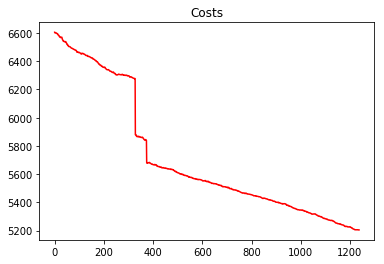

In [237]:
see_annealing(states, costs)

The annealing schedule is able to find an optimal solution for the function as shown in the decreasing graph of the cost